In [1]:
import topological_learning as tl
import topological_learning.datasets as ds
import topological_learning.preprocessing as prep
import topological_learning.diagram as diag
import topological_learning.homology as hl
import numpy as np
import pandas as pd
import datetime as dt
import sklearn as sk
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

/home/shared_envs/research_env/lib/python3.6/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /home/l2f.ch/g.tauzin/software/topological_learning/topological_learning/dependencies/gudhi_bottleneck.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)

Error compiling Cython file:
------------------------------------------------------------
...
    if e is None:
        # Default value is the smallest double value (not 0, 0 is for exact version)
        return bottleneck(diagram_1, diagram_2)
    else:
        # Can be 0 for exact version
        return bottleneck(diagram_1, diagram_2, e)
                        ^
------------------------------------------------------------

/home/l2f.ch/g.tauzin/software/topological_learning/topological_learning/dependencies/gudhi_bottleneck.pyx:62:25: Call with wrong number of arguments (expected 2, got 3)


Using original gudhi bottleneck_distance.


In [2]:
import topological_learning.manifold as ma

test = tl.manifold.StatefulMDS()

In [3]:
maxDuration = 20000
transitionList = [0.037500000000000006, 0.047, 0.0625, 0.077, 0.10350000000000001, 0.1275, 0.1585, 0.1615, 
                  0.1685, 0.2215, 0.23, 0.23700000000000002, 0.2515, 0.2715, 0.3, 0.30750000000000005, 0.3385, 
                  0.36350000000000005, 0.388, 0.40449999999999997, 0.41950000000000004, 0.4225, 0.4515, 
                  0.46950000000000003, 0.506, 0.5405, 0.542, 0.5825, 0.5825, 0.6144999999999999, 0.635, 0.66, 
                  0.677, 0.6845, 0.685, 0.729, 0.749, 0.769, 0.777, 0.8075, 0.8310000000000001, 0.833, 0.864, 
                  0.8674999999999999, 0.882, 0.903, 0.9395, 0.94, 0.974, 0.99]
lorenzAttractor = ds.LorenzDataset(initialConditions=(1, -10, 10), sigma=10., beta=8./3., rhoMin=5, rhoMax=15,
                     transitionList=transitionList, numberTransitions=25, transitionDuration=100,
                     timeStep=0.01, maxDuration=maxDuration, meanNoise=0., stdDeviationNoise=0.0)
lorenzAttractor.run()

In [4]:
title = 'Lorenz attractor'
trace = go.Scatter3d(x=lorenzAttractor.x, y=lorenzAttractor.y, z=lorenzAttractor.z, mode='markers',
                     marker=dict(size=4, color=list(range(maxDuration)),
                     colorscale='Viridis', opacity=0.8))

data = [trace]
layout = go.Layout(margin=dict(l=0, r=0, b=0, t=0))

figure = go.Figure(data=data, layout=layout)
iplot(figure)

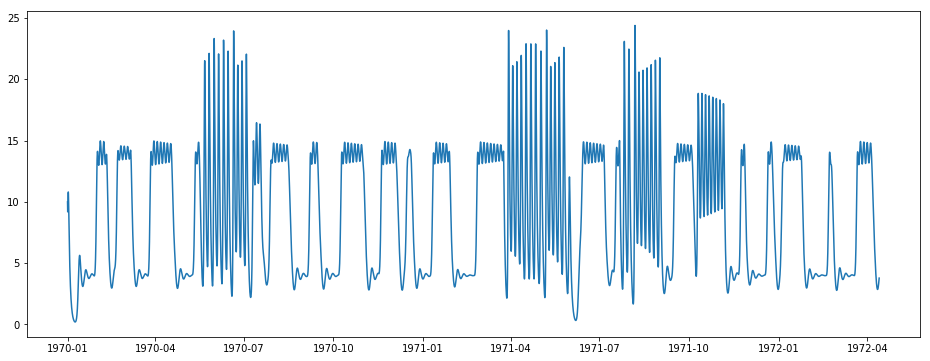

In [5]:
zDataFrame = pd.DataFrame(lorenzAttractor.z)
index = pd.to_datetime(zDataFrame.index, utc=True, unit='h')
zDataFrame.index = index

fig = plt.figure(figsize=(16,6))
plt.plot(zDataFrame)
plt.show()

In [6]:
samplingPeriod = '10h'
periodicSampler = prep.Resampler(sampling_type='periodic', sampling_period=samplingPeriod, remove_weekends=False)

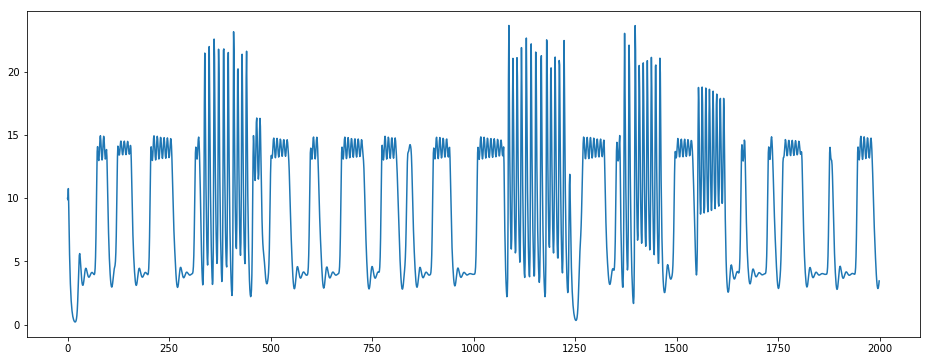

In [7]:
periodicSampler.fit(zDataFrame)
zDataFrameSampled = periodicSampler.transform(zDataFrame)

fig = plt.figure(figsize=(16,6))
plt.plot(zDataFrameSampled)
plt.show()

In [8]:
outerWindowDuration = 100
outerWindowStride = 20
embedder = prep.TakensEmbedder(outer_window_duration=outerWindowDuration, outer_window_stride=outerWindowStride, 
                              embedding_parameters_type='search', embedding_dimension=10, embedding_time_delay=3, 
                              n_jobs=-1)

In [9]:
embedder.fit(zDataFrameSampled)
zEmbedded = embedder.transform(zDataFrameSampled)
print('Optimal embedding time delay based on mutual information: ', embedder.embedding_time_delay)
print('Optimal embedding dimension based on false nearest neighbors: ', embedder.embedding_dimension)

Optimal embedding time delay based on mutual information:  3
Optimal embedding dimension based on false nearest neighbors:  7


In [10]:
windowNumber = 3

In [11]:
title = 'Takens embedding of the first outer window'
window = zEmbedded[windowNumber]
trace = go.Scatter3d(x=window[:, 0], y=window[:, 1], z=window[:, 2], mode='markers',
                     marker=dict(size=4, color=list(range(window.shape[0])),
                     colorscale='Viridis', opacity=0.8))

data = [trace]
layout = go.Layout(margin=dict(l=0, r=0, b=0, t=0))

figure = go.Figure(data=data, layout=layout)
iplot(figure)

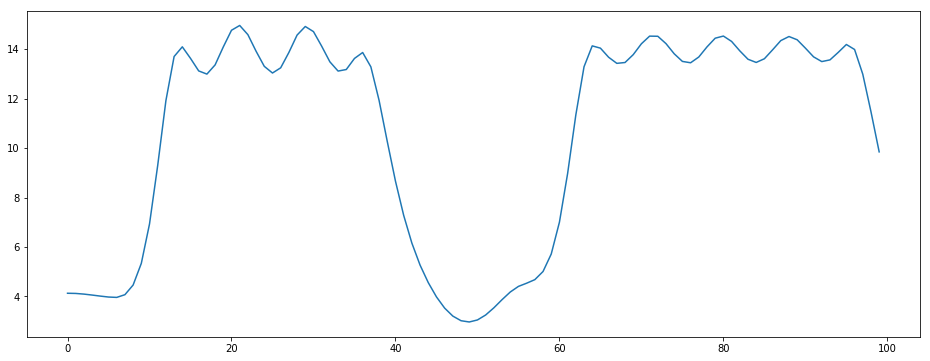

In [12]:
fig = plt.figure(figsize=(16,6))
plt.plot(zDataFrameSampled[windowNumber*outerWindowStride:windowNumber*outerWindowStride + outerWindowDuration])
plt.show()

In [13]:
homologyDimensions = [0, 1 ,2]
persistenceDiagram = hl.VietorisRipsPersistence(data_type='points', max_edge_length=100, 
                                            homology_dimensions=homologyDimensions, n_jobs=-1)
persistenceDiagram.fit(zEmbedded)
zDiagrams = persistenceDiagram.transform(zEmbedded)

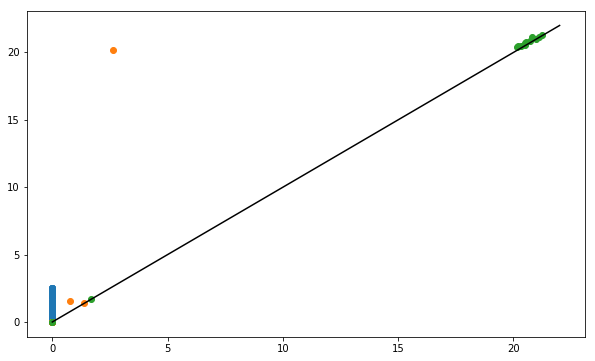

In [14]:
fig = plt.figure(figsize=(10,6))
diagram = { dimension: zDiagrams[dimension][windowNumber] for dimension in homologyDimensions }

for dimension in homologyDimensions:
    plt.plot(diagram[dimension][:,0], diagram[dimension][:,1], 'o')

plt.plot([0, 22], [0, 22], color='k')
plt.show()

In [15]:
diagramDistance = diag.DiagramDistance(metric='bottleneck', metric_params={'order': np.inf}, n_jobs=-1)
diagramDistance.fit(zDiagrams)
zDistanceMatrix_BN = diagramDistance.transform(zDiagrams)

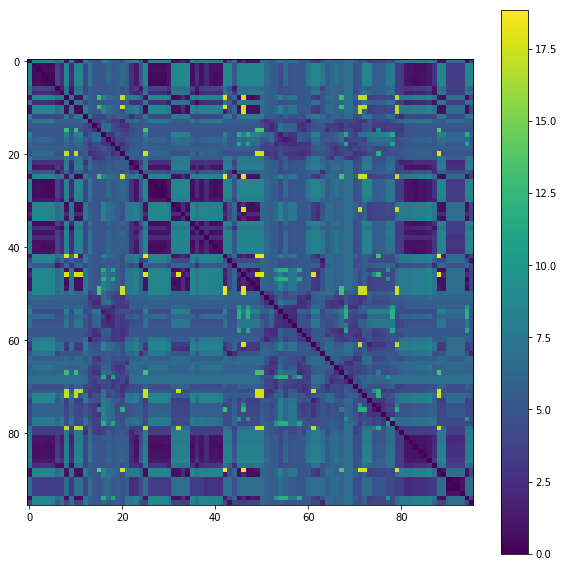

In [16]:
figure = plt.figure(figsize=(10,10))
plt.imshow(zDistanceMatrix_BN)
plt.colorbar()
plt.show()

In [17]:
diagramDistance = diag.DiagramDistance(metric='landscape', metric_params={'order': 2, 'n_layers':1, 'n_samples':1000}, 
                                       n_jobs=-1)
diagramDistance.fit(zDiagrams)
zDistanceMatrix_L = diagramDistance.transform(zDiagrams)

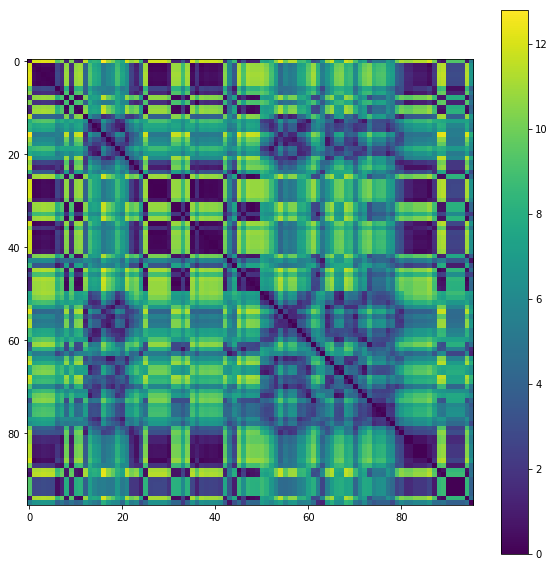

In [18]:
figure = plt.figure(figsize=(10,10))
plt.imshow(zDistanceMatrix_L)
plt.colorbar()
plt.show()

In [19]:
lorenzAttractor.stdDeviationNoise = 0.3
lorenzAttractor.run()

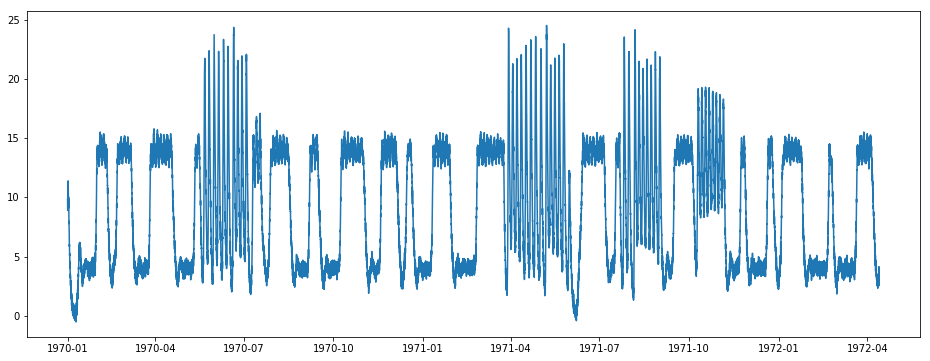

In [20]:
zDataFrame_noise = pd.DataFrame(lorenzAttractor.z)
index = pd.to_datetime(zDataFrame_noise.index, utc=True, unit='h')
zDataFrame_noise.index = index

fig = plt.figure(figsize=(16,6))
plt.plot(zDataFrame_noise)
plt.show()

In [21]:
steps = [
    ('sampling', prep.Resampler(sampling_type='periodic', sampling_period=samplingPeriod, remove_weekends=False)),
    ('embedding', prep.TakensEmbedder(outer_window_duration=outerWindowDuration, outer_window_stride=outerWindowStride, 
                              embedding_parameters_type='search', embedding_dimension=10, embedding_time_delay=3, 
                              n_jobs=-1)),
    ('diagrams', hl.VietorisRipsPersistence(data_type='points', max_edge_length=100, 
                                        homology_dimensions=homologyDimensions, n_jobs=-1))
]

# Sklearn Pipeline
pipeline = Pipeline(steps)

In [22]:
pipeline.fit(zDataFrame_noise)
zDiagrams_noise = pipeline.transform(zDataFrame_noise)

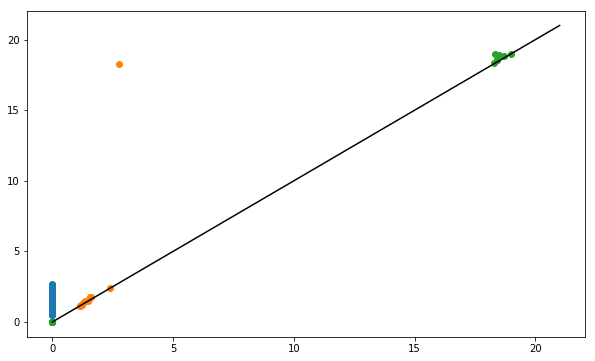

In [23]:
fig = plt.figure(figsize=(10,6))
diagram = { dimension: zDiagrams_noise[dimension][windowNumber] for dimension in homologyDimensions }

for dimension in homologyDimensions:
    plt.plot(diagram[dimension][:,0], diagram[dimension][:,1], 'o')

plt.plot([0, 21], [0, 21], color='k')
plt.show()

In [24]:
diagramScaler = diag.DiagramScaler()
diagramScaler.fit(zDiagrams_noise)
zDiagramsScaled_noise = diagramScaler.transform(zDiagrams_noise)

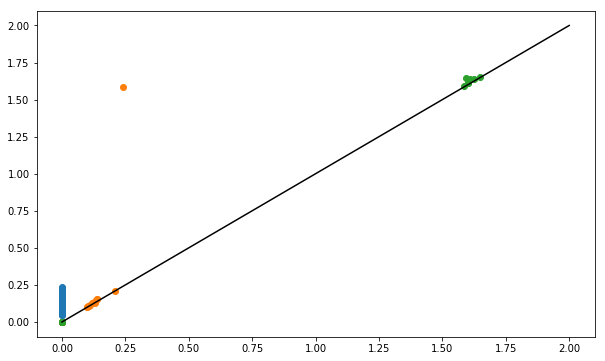

In [25]:
fig = plt.figure(figsize=(10,6))
diagram = { dimension: zDiagramsScaled_noise[dimension][windowNumber] for dimension in homologyDimensions }

for dimension in homologyDimensions:
    plt.plot(diagram[dimension][:,0], diagram[dimension][:,1], 'o')

plt.plot([0, 2], [0, 2], color='k')
plt.show()

In [26]:
diagramFilter = diag.DiagramFilter(delta=0.05, homology_dimensions={1, 2})
diagramFilter.fit(zDiagramsScaled_noise)
zDiagramsFiltered_noise = diagramFilter.transform(zDiagramsScaled_noise)

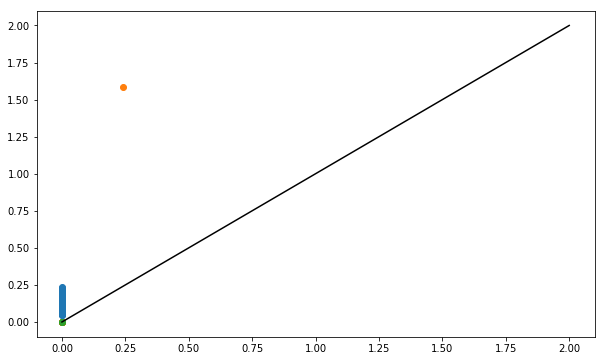

In [27]:
fig = plt.figure(figsize=(10,6))
diagram = { dimension: zDiagramsFiltered_noise[dimension][windowNumber] for dimension in homologyDimensions }

for dimension in homologyDimensions:
    plt.plot(diagram[dimension][:,0], diagram[dimension][:,1], 'o')

plt.plot([0, 2], [0, 2], color='k')
plt.show()

In [28]:
steps = [
    ('sampling', prep.Resampler(sampling_type='periodic', sampling_period=samplingPeriod, remove_weekends=False)),
    ('embedding', prep.TakensEmbedder(outer_window_duration=outerWindowDuration, outer_window_stride=outerWindowStride, 
                              embedding_parameters_type='search', embedding_dimension=10, embedding_time_delay=10, 
                              n_jobs=-1)),
    ('diagrams', hl.VietorisRipsPersistence(data_type='points', max_edge_length=100, 
                                        homology_dimensions=homologyDimensions, n_jobs=-1)),
    ('diagrams_scaler', diag.DiagramScaler()),
    ('diagrams_filter', diag.DiagramFilter(delta=0.05))
]

pipeline_filter = Pipeline(steps)

In [29]:
pipeline_filter.fit(zDataFrame_noise)
zDiagramsFilteredPipeline_noise = pipeline_filter.transform(zDataFrame_noise)

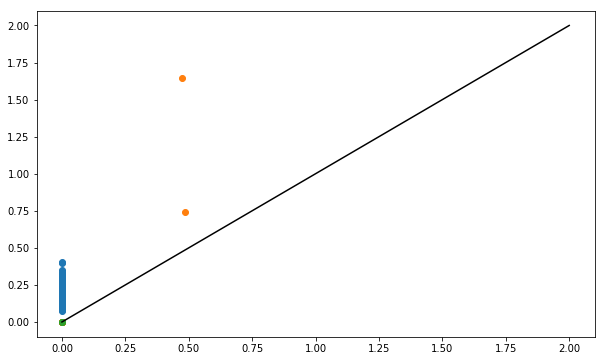

In [30]:
fig = plt.figure(figsize=(10,6))
diagram = { dimension: zDiagramsFilteredPipeline_noise[dimension][windowNumber] for dimension in homologyDimensions }

for dimension in homologyDimensions:
    plt.plot(diagram[dimension][:,0], diagram[dimension][:,1], 'o')

plt.plot([0, 2], [0, 2], color='k')
plt.show()